<a href="https://colab.research.google.com/github/h0806449f/TensorFlow/blob/main/Tibame_TensorFlow_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobel
1. 3*3 以某像素為中心, 擷取特徵
2. 為何是3*3 : GPU 優化處理過
3. 為何不用5*5 ... : 利用深度替代
4. 如何擷取特徵 : 透過9個數值差, 來強調`邊緣`

In [1]:
from urllib.request import urlretrieve

url = "https://github.com/Elwing-Chou/tibaml0315/raw/main/bg%20morning.png"
urlretrieve(url, "test.png")

('test.png', <http.client.HTTPMessage at 0x7f02f8392110>)

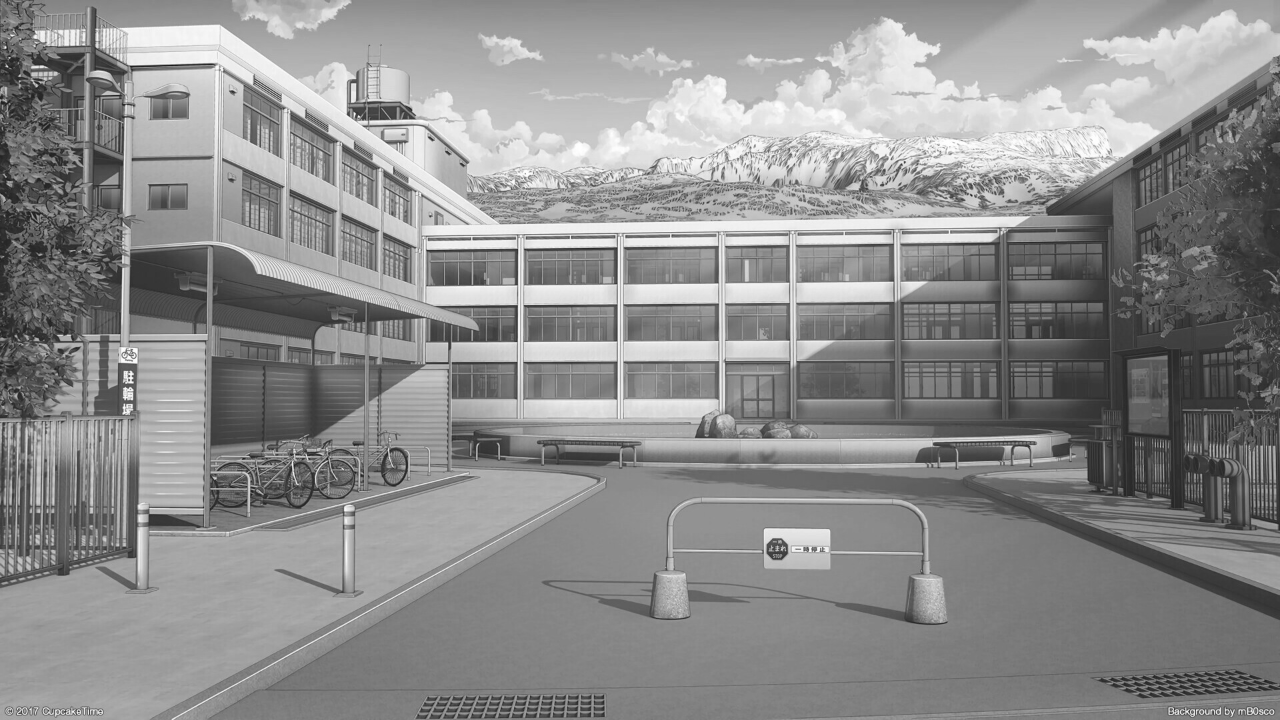

In [2]:
import numpy as np
from PIL import Image

img = Image.open("test.png").convert("L")
img_np = np.array(img)
img

In [3]:
img_np.shape

(720, 1280)

In [4]:
# Gx  (直線)

Gx = [
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]

def combine(img, ci, cj, g):
    # ci, cj: center -1: top left
    si, sj = ci-1, cj-1
    total = 0.0
    for i in range(3):
        for j in range(3):
            total = total + img[si+i][sj+j] * g[i][j]
    return abs(total)

img_gx = np.zeros(img_np.shape)
h, w = img_np.shape
for i in range(1, h-1):
    for j in range(1, w-1):
        img_gx[i][j] = combine(img_np, i, j, Gx)

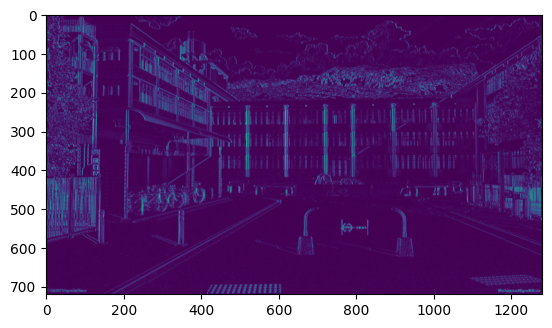

In [5]:
import matplotlib.pyplot as plt

# 0~255(ok) 0.0~1.0(ok)
# 0~1: (pi - min) / (max - min)
ma = img_gx.max()
mi = img_gx.min()
img_norm = (img_gx - mi) / (ma - mi)
plt.imshow(img_norm)

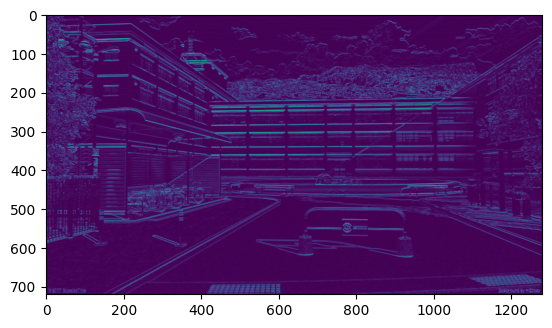

In [6]:
# Gy  (橫線)

Gy = [
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
]

img_gy = np.zeros(img_np.shape)
h, w = img_np.shape
for i in range(1, h-1):
    for j in range(1, w-1):
        img_gy[i][j] = combine(img_np, i, j, Gy)

ma = img_gy.max()
mi = img_gy.min()
img_norm = (img_gy - mi) / (ma - mi)
plt.imshow(img_norm)

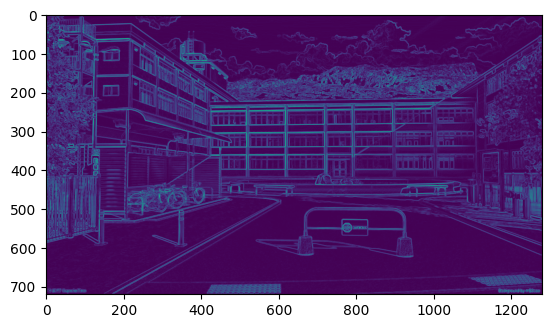

In [7]:
#　Gx + Gy

img_g = (img_gx ** 2 + img_gy ** 2) ** 0.5
ma = img_g.max()
mi = img_g.min()
img_norm = (img_g - mi) / (ma - mi)
plt.imshow(img_norm)

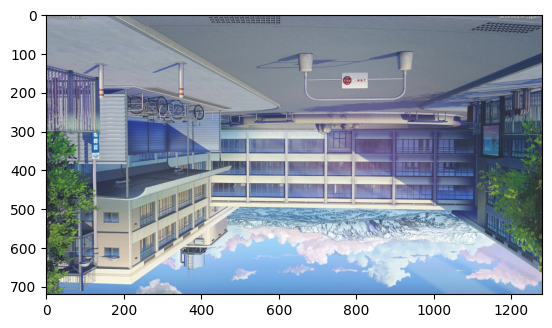

In [8]:
# 圖像操作  (np.array操作 -> 對某一個軸, 都進行一個list操作)

img = Image.open("test.png").convert("RGB")
img_np = np.array(img)

# 左右相反
plt.imshow(img_np[:, ::-1, :])

# 上下相反
plt.imshow(img_np[::-1, :, :])

# CIFAR 10


In [1]:
# import datasets

from tensorflow.keras.datasets import cifar10
( (x_train, y_train), (x_test, y_test) ) = cifar10.load_data()

170498071/170498071 [==============================] - 7s 0us/step


In [2]:
# check shape

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
# (50000, 1) 原資料型態是為了未來擴充達案的可能性, 這邊不需要, 所以reshape

y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

In [4]:
# 轉換答案的list
trans = [ 
    "airplane",										
    "automobile",										
    "bird",										
    "cat",										
    "deer",										
    "dog",										
    "frog",										
    "horse",										
    "ship",										
    "truck"
]

dog


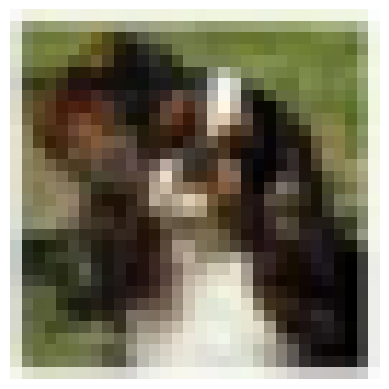

In [7]:
# check image

from PIL import Image
import matplotlib.pyplot as plt

index = 500
plt.imshow(x_train[index])
plt.axis("off")

print(trans[y_train[index]])

In [8]:
# build model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

layers = [
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation="relu"),
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dense(10, activation="softmax")
]

model = Sequential(layers)
model.summary()

# summary 解析
# filter 3 * 3   RGB 3
# conv 64
# 27 * 64 + 64 = 1792 

# filter 3 * 3   64
# conv 128
# 576 * 128 + 128 = 73856

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                    

In [9]:
# 資料預處理
# x : 0 ~ 1
# y : one-hot encoding (轉為10個機率)
# CIFAR10 僅有10種分類, 為了避免日後大量分類的任務 -> 稀疏矩陣 Sparse
# y : 配合loss 使用 SparseCategoricalCrossentropy -> 第0類, Spare 自動轉為index0 = 1

x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

In [10]:
# compile (確定損失函式)
# 避免分類太多而消耗過多的RAM
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# optimizer
# 局部最佳 vs 全局最佳
# 使用 optimizer 是為了避免分析結果停在 "鞍點" (局部最佳, 全局最佳, 通常差異不會太大)
# 速度, 時間&步長 優化 -> adam 一次全部解決

model.compile(loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
        optimizer="adam")

In [11]:
# fit
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callback_list = [
    ModelCheckpoint("cifar10.h5", save_best_only=True),
    EarlyStopping(patience=7, restore_best_weights=True)
]
model.fit(x_train_norm,
     y_train,
     batch_size=100,
     epochs=40,
     validation_split=0.1,
     callbacks=callback_list)

Epoch 1/40
450/450 [==============================] - 22s 21ms/step - loss: 1.6290 - accuracy: 0.3919 - val_loss: 1.2390 - val_accuracy: 0.5388
Epoch 2/40
450/450 [==============================] - 9s 20ms/step - loss: 1.0680 - accuracy: 0.6177 - val_loss: 0.8571 - val_accuracy: 0.7014
Epoch 3/40
450/450 [==============================] - 9s 20ms/step - loss: 0.7901 - accuracy: 0.7192 - val_loss: 0.7239 - val_accuracy: 0.7452
Epoch 4/40
450/450 [==============================] - 9s 20ms/step - loss: 0.6219 - accuracy: 0.7826 - val_loss: 0.6215 - val_accuracy: 0.7902
Epoch 5/40
450/450 [==============================] - 9s 20ms/step - loss: 0.5068 - accuracy: 0.8232 - val_loss: 0.6172 - val_accuracy: 0.7968
Epoch 6/40
450/450 [==============================] - 9s 20ms/step - loss: 0.4040 - accuracy: 0.8595 - val_loss: 0.5813 - val_accuracy: 0.8032
Epoch 7/40
450/450 [==============================] - 9s 19ms/step - loss: 0.3199 - accuracy: 0.8884 - val_loss: 0.5851 - val_accuracy: 0.816

In [12]:
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.6187 - accuracy: 0.7967


[0.6187424063682556, 0.7967000007629395]

In [13]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pre = model.predict(x_test_norm).argmax(axis=1)
mat = confusion_matrix(y_test, pre)

pd.DataFrame(mat,
       index=["{}(true)".format(trans[i]) for i in range(10)],
       columns=["{}(pred)".format(trans[i]) for i in range(10)])

313/313 [==============================] - 1s 3ms/step


,airplane(pred),automobile(pred),bird(pred),cat(pred),deer(pred),dog(pred),frog(pred),horse(pred),ship(pred),truck(pred)
airplane(true),861,6,23,8,14,8,8,8,27,37
automobile(true),13,887,5,2,2,4,6,3,9,69
bird(true),76,2,709,24,60,67,39,11,5,7
cat(true),29,7,52,497,72,197,103,21,4,18
deer(true),16,2,60,18,796,36,28,35,6,3
dog(true),11,1,36,73,39,793,25,13,1,8
frog(true),7,2,58,19,29,14,863,2,4,2
horse(true),15,3,32,29,43,65,4,803,1,5
ship(true),58,11,12,9,5,3,6,3,856,37
truck(true),16,44,8,6,4,3,3,6,8,902


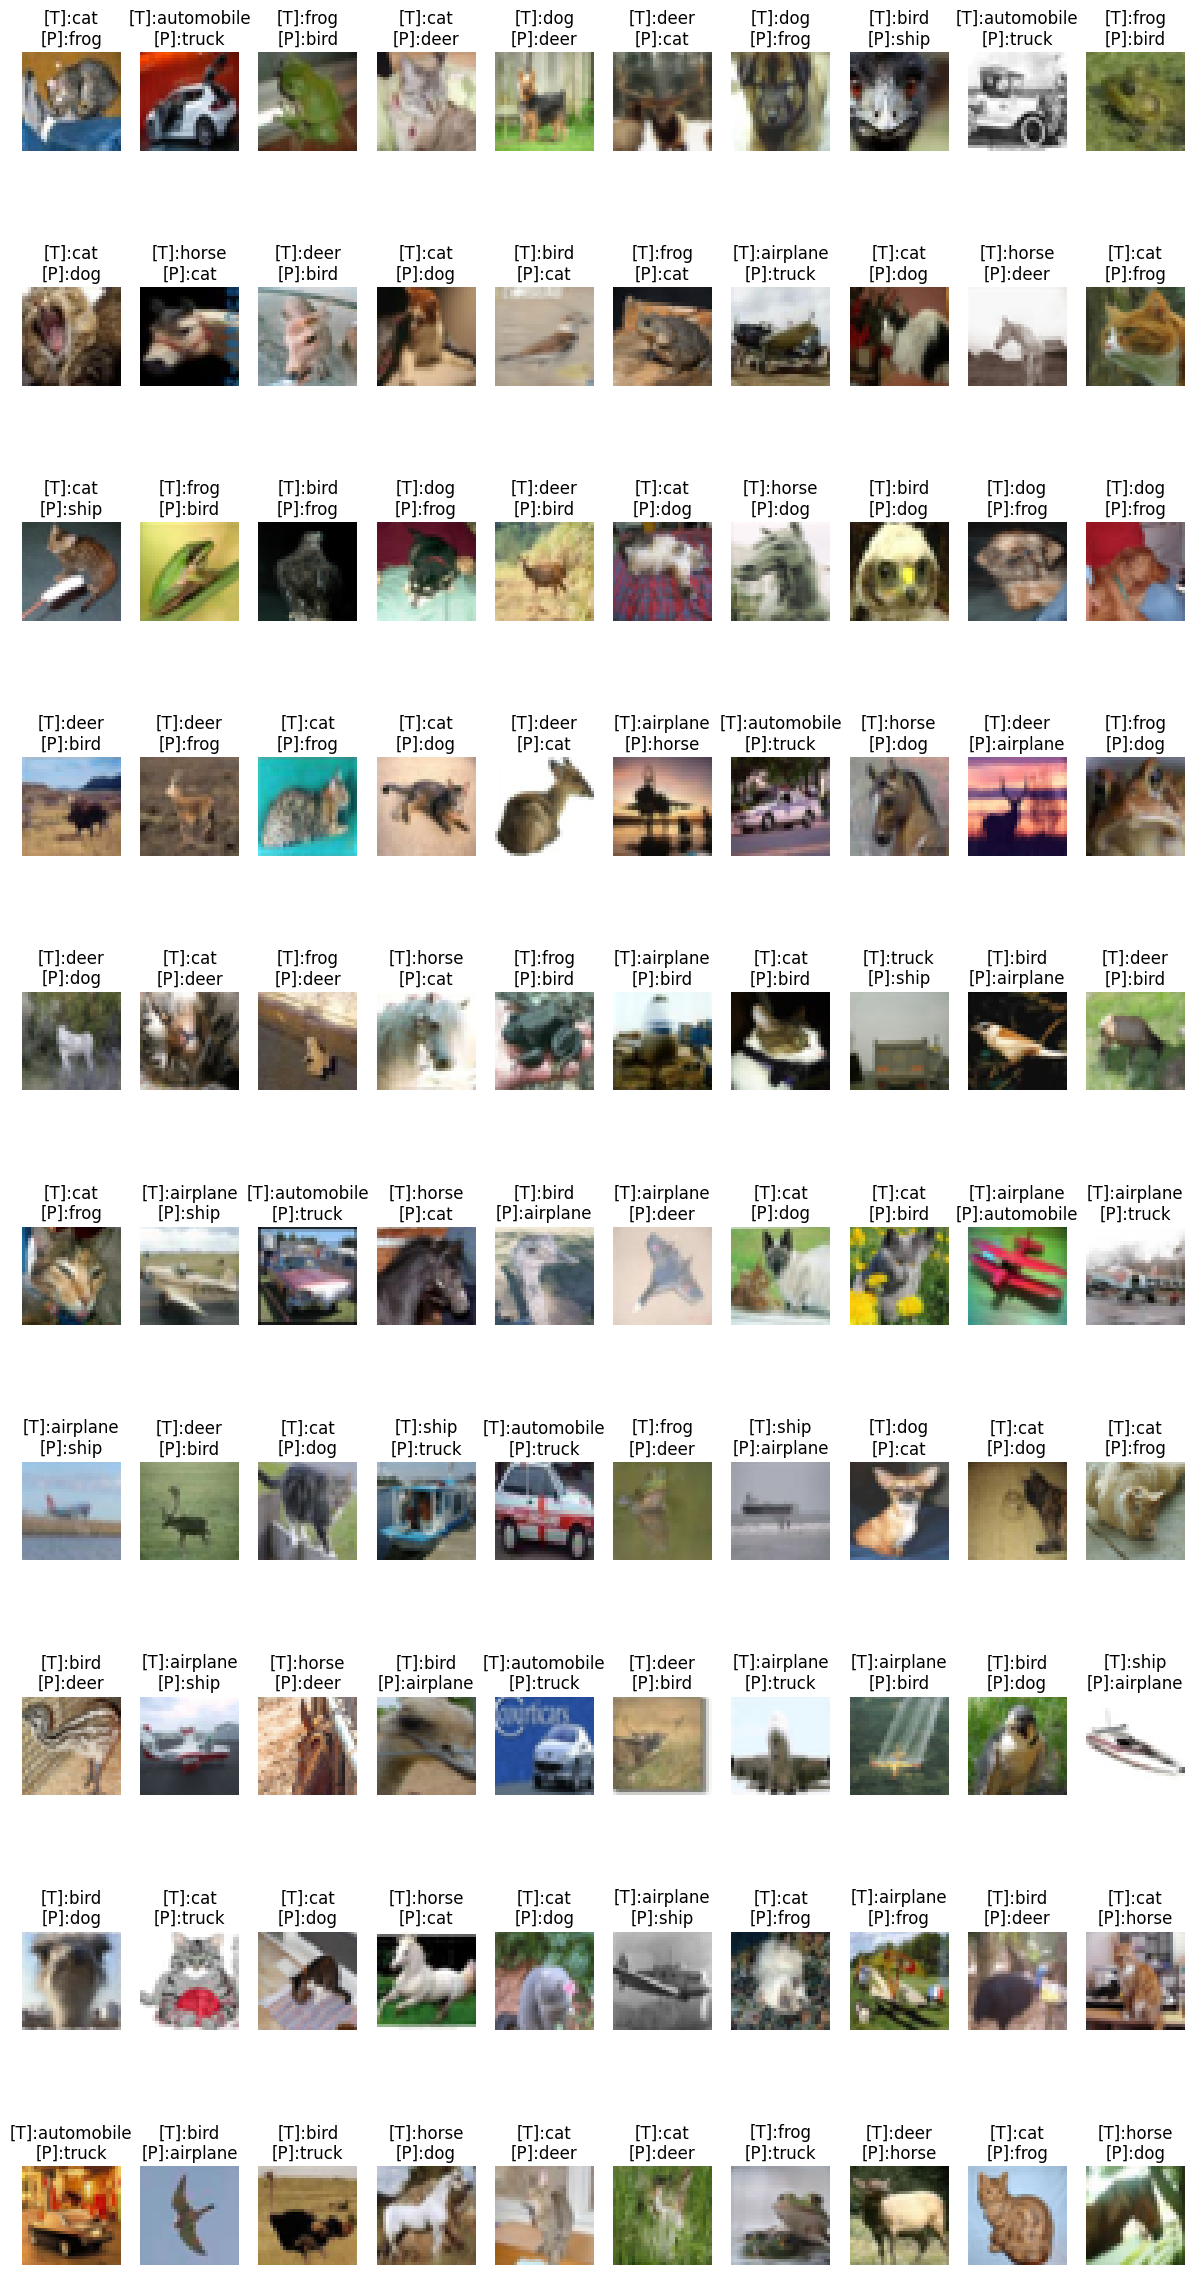

In [14]:
import numpy as np
idx = np.nonzero(y_test != pre)[0]
idx = idx[:100]
plt.figure(figsize=(15, 30))
# 預測錯誤的預測值
fp_pred = pre[idx]
# 預測錯誤的真實值
fp_true = y_test[idx]
# 預測錯誤的圖片
fp_img = x_test[idx]
for i in range(len(idx)):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    t = "[T]:{}\n[P]:{}".format(trans[fp_true[i]], trans[fp_pred[i]])
    plt.title(t)
    plt.imshow(fp_img[i])

# 使用網路圖片, 檢驗模型


1/1 [==============================] - 0s 240ms/step
airplane 的機率是 0.0013
automobile 的機率是 0.0049
bird 的機率是 0.0072
cat 的機率是 0.283
deer 的機率是 0.001
dog 的機率是 0.6342
frog 的機率是 0.0472
horse 的機率是 0.018
ship 的機率是 0.0007
truck 的機率是 0.0025
最高機率是: dog


(-0.5, 31.5, 31.5, -0.5)

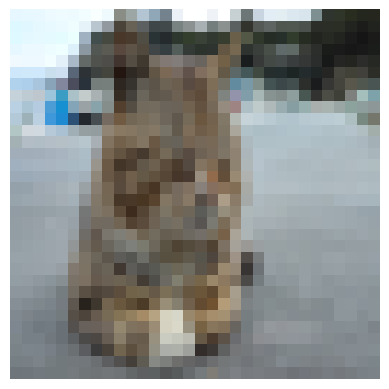

In [15]:
import requests
from PIL import Image

url = "https://www.photolibrary.jp/mhd3/img523/450-20170430131647336221.jpg" #@param {type:"string"}
header = {
    "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36"
}
response = requests.get(url, stream=True, headers=header)

img = Image.open(response.raw).resize((32, 32)).convert("RGB")
img_np = np.array(img)

testx = img_np.reshape(1, 32, 32, 3) / 255.0
probas = model.predict(testx)[0]

for i in range(10):
    print(trans[i], "的機率是", round(probas[i],4))

ans = probas.argmax(axis=-1)
print("最高機率是:", trans[ans])

plt.imshow(img_np)
plt.axis("off")

# 檢視 各層分析結果

In [16]:
# 模型中的所有 : 層
model.layers

1/1 [==============================] - 0s 372ms/step


<ipython-input-18-f008051f7451>:25: RuntimeWarning: invalid value encountered in true_divide
  fil = (fil-mi) / (ma-mi)


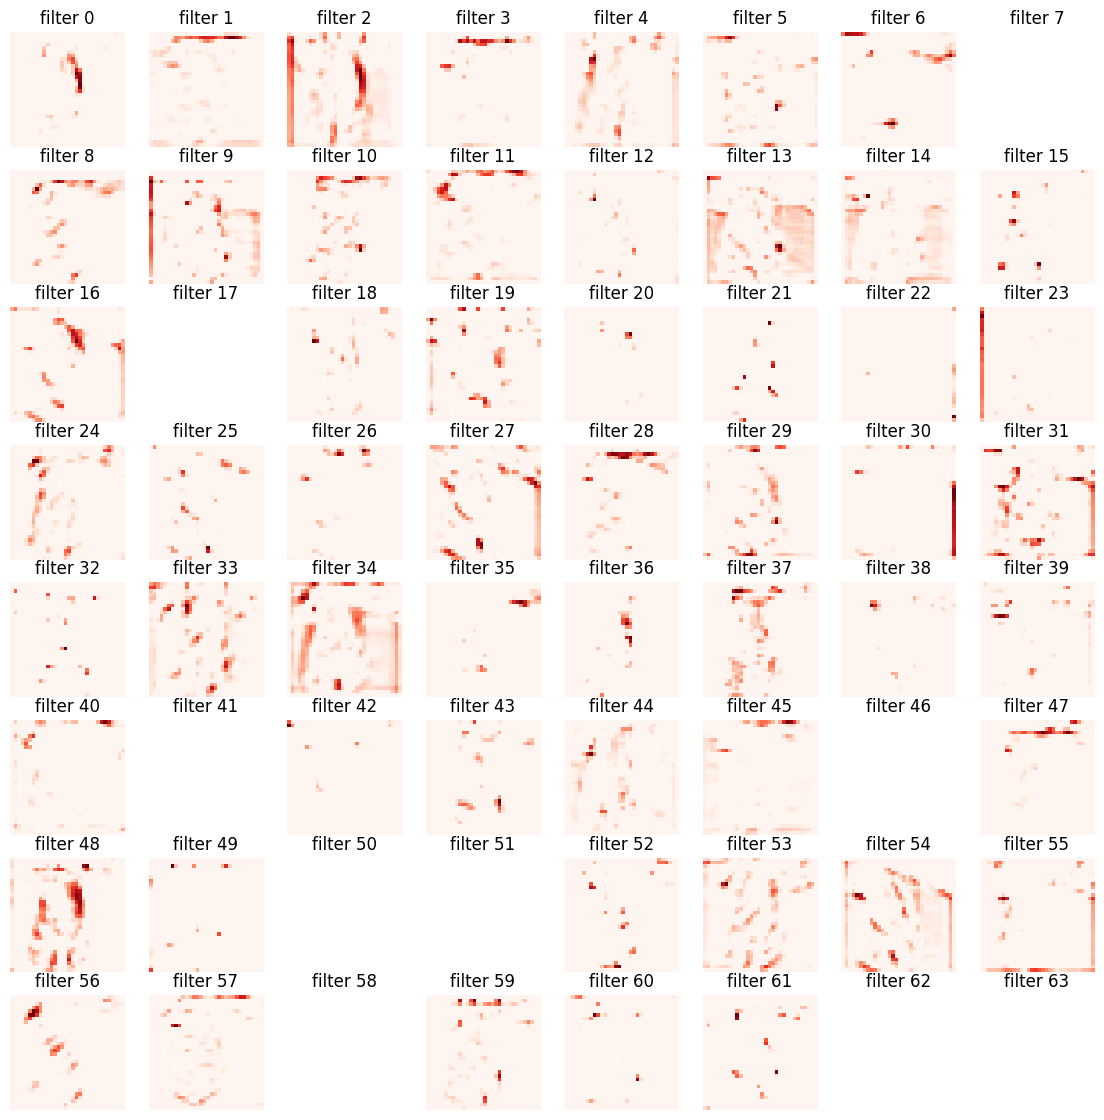

In [18]:
# 第一層
# layers = [model.layers[0]]

# 
layers = [
    model.layers[0],
    model.layers[1],
    model.layers[3],
    model.layers[4]
]

# 僅用某幾層, 做出一個暫時的模型
temp_model = Sequential(layers)

conv = temp_model.predict(img_np.reshape(1, 32, 32, 3))[0]
plt.figure(figsize=(14, 14))

# 第二層 擷取64種特徵 找出其中一種來看
for i in range(64):
    idx = i
    fil = conv[:,:,i]

    # 0~1
    ma, mi = fil.max(), fil.min()
    fil = (fil-mi) / (ma-mi)
    title = "filter {}".format(i)

    # subplot
    plt.subplot(8, 8, i+1)
    plt.title(title)
    plt.axis("off")
    plt.imshow(fil, cmap="Reds")

# 模型 - 儲存 & 再使用

In [20]:
# HDFVIEW

#　讀取
import os
from tensorflow.keras.models import load_model
temp = load_model("cifar10.h5")
temp.evaluate(x_test_norm, y_test)

# 儲存
model.save("cifar10.h5")

# 有的話就讀, 沒有的話就建立模型
if not os.path.exists("cifar10.h5"):
    # model = Sequential(layers)
    # model.compile(loss=xxx)
    pass
else:
    model = load_model("cifar10.h5") 

313/313 [==============================] - 2s 4ms/step - loss: 0.6187 - accuracy: 0.7967
